In [ ]:
from typing import Dict, Any
from IPython.display import display
from graphviz import Digraph
import numpy as np
import pandas as pd


def entropy(y: np.ndarray) -> float:
    """Calculate the entropy of a target array."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / y.shape[0]
    return -np.sum(probs * np.log(probs + 1e-10))


def information_gain(X: np.ndarray, y: np.ndarray, feature_idx: int) -> float:
    """Calculate the information gain for a given feature."""
    parent_entropy = entropy(y)

    values, counts = np.unique(X[:, feature_idx], return_counts=True)
    probs = counts / y.shape[0]
    entropies = np.array(
        list(map(lambda x: entropy(y[X[:, feature_idx] == x]), values))
    )
    conditional_entropy = np.sum(probs * entropies)

    return parent_entropy - conditional_entropy


def select_best_feature(X: np.ndarray, y: np.ndarray, features: list) -> list:
    """Select the feature with the highest information gain."""
    best_idx = np.argmax([information_gain(X, y, i) for i in range(X.shape[1])])
    return [best_idx, features[best_idx]]


def id3_algorithm(X: np.ndarray, y: np.ndarray, features: list) -> Dict[str, Any]:
    """Recursively build the ID3 decision tree."""
    classes, counts = np.unique(y, return_counts=True)

    majority_class = classes[np.argmax(counts)]

    # Base case: all samples same class
    if len(classes) == 1 or not features:
        return {"class": classes[0], "majority_class": classes[0]}

    best_id, best_feature = select_best_feature(X, y, features)
    feature_values = np.unique(X[:, best_id])
    new_features = features.copy()
    new_features.remove(best_feature)

    tree = {"feature": best_feature, "majority_class": majority_class, "children": {}}

    for value in feature_values:
        mask = X[:, best_id] == value
        X_sub, y_sub = np.delete(X, best_id, axis=1)[mask], y[mask]
        if len(y_sub) == 0:
            tree["children"][value] = {
                "class": majority_class,
                "majority_class": majority_class,
            }
        else:
            tree["children"][value] = id3_algorithm(X_sub, y_sub, new_features)

    return tree


def visualize_tree(
    tree: Dict[str, Any],
    feature_names: list,
    dot: Digraph = None,
    parent: str = None,
    edge_label: str = None,
) -> Digraph:
    """Recursively visualize the decision tree using Graphviz."""
    if dot is None:
        dot = Digraph(comment="Decision Tree")

    # Create a unique node ID
    node_id = str(id(tree))

    # Add the current node
    if "class" in tree:
        node_label = f"Class: {tree['class']}"
    else:
        node_label = f"Feature: {tree['feature']}"
    dot.node(node_id, node_label)

    # Connect to parent node if exists
    if parent is not None:
        dot.edge(parent, node_id, label=edge_label)

    # Recursively add children
    if "children" in tree:
        for value, child in tree["children"].items():
            visualize_tree(child, feature_names, dot, node_id, str(value))

    return dot


class DecisionTree:
    """
    Decision tree classifier, which can be trained, can predict class labels(miraculously) and display itself if used in a frontend environment.
    """

    def __init__(self):
        self._features = []
        self._tree = {}

    def fit(self, X: np.ndarray, y: np.ndarray, features: list) -> None:
        """Fit the decision tree to passed data."""
        self._features = features
        self._tree = id3_algorithm(X, y, features)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels for given data."""
        ans = np.zeros((X.shape[0], 1), dtype="object")
        for i in range(ans.shape[0]):
            node = self._tree
            while "class" not in node:
                feature_id = self._features.index(node["feature"])
                node = node["children"][X[i, feature_id]]
            ans[i, 0] = node["class"]
        return ans

    def show_tree(self):
        """Visualize the decision tree."""
        dot = visualize_tree(self._tree, self._features)
        display(dot)

In [2]:
dataset = {
    'Taste': ['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
    'Temperature': ['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
    'Texture': ['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
    'Eat': ['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']
}
dataframe = pd.DataFrame(dataset, columns=['Taste','Temperature','Texture','Eat'])

# Prepare features and target
feature_names = dataframe.columns[:-1].tolist()
x_train = dataframe[feature_names].to_numpy()
y_train = dataframe['Eat'].to_numpy()
# features = list(range(len(feature_names)))
classifier = DecisionTree()
classifier.fit(x_train, y_train, feature_names.copy())

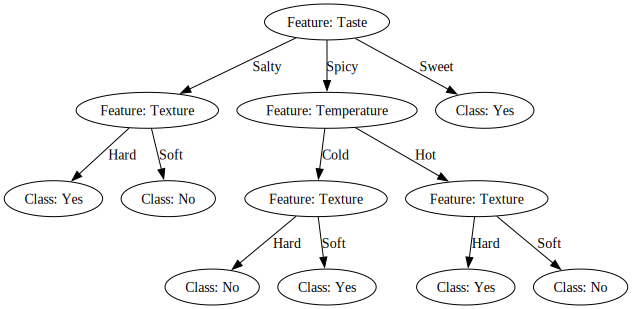

In [3]:
classifier.show_tree()

In [ ]:
x_test = np.array([["Salty", "Hot", "Hard"]], dtype="object")
prediction = classifier.predict(x_test)
print(f"Prediction for the new data point: {prediction}")

Prediction for the new data point: [['Yes']]
